![picture](https://drive.google.com/uc?export=view&id=1D2b96gkI2-g0gRObf9dcl4GBtYWT9Xz4)

# **MSIN0097 Predictive Analytics**

Candidate Numbers: 
ZRMH8  
Word Count: 2051  
Notebook link: https://colab.research.google.com/drive/1-fhtJ4ctBK25ponSI6dU0zKLrGKiLpno?usp=share_link  

---


# Table of Contents
* [Imports](#Imports)
* [1. Introduction](#1.-Introduction)                          
* [2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)
* [3. Data Preparation](#3.-Data-Preparation)
    * [3.1 Feature engineering](#3.1-Feature-engineering)
    * [3.2 Data splitting and reshaping](#3.2-Data-splitting-and-reshaping)
        * [3.2.1 Data splitting](#3.2.1-Data-splitting)
        * [3.2.2 Data preparation for neural network](#3.2.2-Data-preparation-for-neural-network)
* [4 Modeling](#4.-Modeling)
    * [4.1 RamdomForestModel](#4.1-RamdomForestModel)
        * [4.1.1 RandomForest Evaluation](#4.1.1-RandomForest-Evaluation)
        * [4.1.2 Comparison-Full Test set and Prediction](#4.1.2-Comparison-Full-Test-set-and-Prediction)
        * [4.1.3 Granular level prediction comparison for one week](#4.1.3-Granular-level-prediction-comparison-for-one-week)
    * [4.2 RNN](#4.2-RNN)
        * [4.1.1 RNN Evaluation](#4.2.1-RNN-Evaluation)
        * [4.2.2 Comparison-Full Test set and Prediction](#4.1.2-Comparison-Full-Test-set-and-Prediction)
        * [4.2.3 Granular level prediction comparison for one week](#4.2.3-Granular-level-prediction-comparison-for-one-week)
    * [4.3 Baseline Model LSTM](#4.3-Baseline-Model-LSTM)
        * [4.3.1 LSTM Evaluation](#4.3.1-LSTM-Evaluation)
        * [4.3.2 Comparison-Full Test set and Prediction](#4.3.2-Comparison-Full-Test-set-and-Prediction)
        * [4.3.3 Granular level prediction comparison for one week](#4.3.3-Granular-level-prediction-comparison-for-one-week)       
    * [4.4 Fine_tuned LSTM LSTM](#4.4-Fine_tuned-LSTM)
        * [4.4.1 Tuned LSTM Evaluation](#4.4.1-Tuned-LSTM-Evaluation)
        * [4.4.2 Comparison-Full Test set and Prediction](#4.4.2-Comparison-Full-Test-set-and-Prediction)
        * [4.4.3 Granular level prediction comparison for one week](#4.4.3-Granular-level-prediction-comparison-for-one-week)        
    * [4.5 Fine_tuned LSTM with Learning rate schedule](#4.5-Fine_tuned-LSTM-with-Learning-rate-schedule)
        * [4.5.1 Scheduled LSTM Evaluation](#4.5.1-Scheduled-LSTM-Evaluation)
        * [4.5.2 Comparison-Full Test set and Prediction](#4.5.2-Comparison-Full-Test-set-and-Prediction)
        * [4.5.3 Granular level prediction comparison for one week](#4.5.3-Granular-level-prediction-comparison-for-one-week)          
* [5. Result and Conclusion](#5.-Result-and-Conclusion)
    * [5.1 Future Prediction using scheduled LSTM](#5.1-Future-Prediction-using-scheduled-LSTM)
        * [5.1.1 Monthly Prediction](#5.1.1-Monthly-Prediction)
        * [5.1.2 Weekly Prediction](#5.1.2-Weekly-Prediction)    
    * [5.2 Model Evaluation](#5.2-Model-Evaluation)
* [6. Limitation](#6.-Limitation)
* [7. Bibliography](#7.-Bibliography)
* [8. Appendix](#8.-Appendix)
    

# Imports

In [157]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
import holidays
import datetime

from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## for Deep-learing:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
# from keras.utils import to_categorical
# from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM, SimpleRNN, Dense
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from transformers import AdamWeightDecay
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import load_model
np.random.seed(42)

# **1. Introduction**


Since the second half of 2021, UK energy price started soaring. One possible reason is that the war between Ukraine and Russia has made the global supply of gas drop rapidly, which lead to the imbalance between supply and demand causing the price of energy rising. In other word, if the supply of the gas is known low already, the increasing demand of the electricity would exacerbate the energy crisis. Therefore, the need of accurately forecasting the electricity demand is crucial not only to ensure a stable and reliable power supply to meet the energy needs of customers, but to prepare the government to take measurements controlling the price of energy, allocating the resources to schedule power generation or could even reduce the unnecessary expenditures on infrastructure.  

Therefore, throughout this project we would be using differernt machine laerning algorithms and neural networks, including Random forest, LSTM and RNN, to predict the future 30 days Transmission System Demand from January 27th and compare the results.


#  **2. Exploratory Data Analysis**

The data is retrieved from the API of the National Grid ESO which is the electricity system operator for Great Britain.  
The full dataset ranges from 2009 to 2023 recorded every half an hour including the variables below, the definition could be seen in the appendix:  

In [279]:
df = pd.read_csv('/project/historic_demand_2009_2023_noNaN.csv')
df["settlement_date"] = pd.to_datetime(df["settlement_date"])
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

In [280]:
df.head()

,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
settlement_date,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
2009-01-01 00:30:00,2,0:30:00,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2009-01-01 01:00:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
2009-01-01 01:30:00,4,1:30:00,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
2009-01-01 02:00:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1


In [39]:
df.describe()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
count,245924.000000,245924.000000,245924.000000,245924.000000,245924.000000,245924.000000,245924.000000,245924.000000,245924.000000,245924.000000,245924.000000,245924.000000,245924.000000,245924.000000,245924.000000,245924.000000,245924.000000
mean,24.497381,31891.714025,33338.949025,29008.567496,1203.606509,4175.984914,791.237016,7683.014224,7.552065,322.302394,924.593671,5.354227,539.354414,-106.701802,-24.005246,145.429076,0.022641
std,13.852041,7792.021253,7590.041443,7064.898564,921.907829,1916.116299,1589.817577,5482.527993,41.633913,546.096731,1093.974555,298.515511,508.708797,221.201852,250.920475,384.738848,0.148757
min,1.000000,13367.000000,16629.000000,0.000000,0.000000,1403.000000,0.000000,0.000000,-24.000000,0.000000,-2056.000000,-1030.000000,-1215.000000,-505.000000,-585.000000,-1022.000000,0.000000
25%,12.000000,25674.000000,27313.000000,23344.750000,515.000000,2085.000000,0.000000,1801.000000,0.000000,8.000000,214.000000,0.000000,0.000000,-251.000000,-125.000000,0.000000,0.000000
50%,24.000000,31327.000000,32547.000000,28470.000000,962.000000,4126.000000,0.000000,9184.000000,0.000000,12.000000,1273.000000,0.000000,762.000000,-118.000000,0.000000,0.000000,0.000000
75%,36.000000,37636.000000,38796.000000,34261.000000,1635.000000,6182.000000,718.000000,13080.000000,0.000000,477.000000,1902.000000,0.000000,994.000000,45.000000,8.000000,0.000000,0.000000
max,48.000000,59095.000000,60147.000000,53325.000000,5354.000000,6574.000000,9680.000000,13861.000000,893.000000,2019.000000,2066.000000,1016.000000,1143.000000,499.000000,504.000000,1033.000000,1.000000


The following graphs are the trend of potential variables that would be used as features to predict the electricity demand and the possible output variables. As can be seen in the diagram, the trend of demand is decrementing, while the other features are increaseing over time.

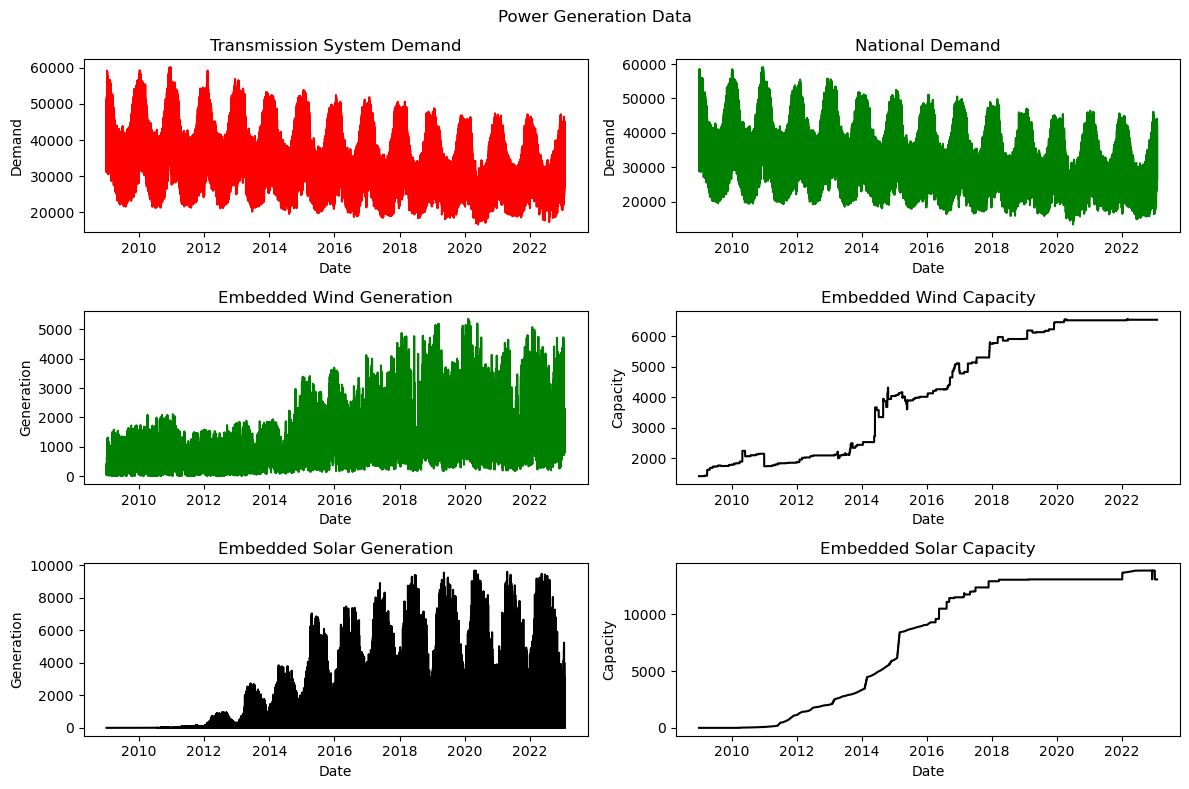

In [282]:
# Create the subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
fig.suptitle('Power Generation Data')

# Plot the first subplot
axs[0, 0].plot(df.index, df['tsd'], color='red')
axs[0, 0].set_title('Transmission System Demand')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Demand')

# Plot the second subplot
axs[0, 1].plot(df.index, df['nd'], color='green')
axs[0, 1].set_title('National Demand')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Demand')

# Plot the third subplot
axs[1, 0].plot(df.index, df['embedded_wind_generation'], color='green')
axs[1, 0].set_title('Embedded Wind Generation')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Generation')

# Plot the fourth subplot
axs[1, 1].plot(df.index, df['embedded_wind_capacity'], color='black')
axs[1, 1].set_title('Embedded Wind Capacity')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Capacity')

# Plot the fifth subplot
axs[2, 0].plot(df.index, df['embedded_solar_generation'], color='black')
axs[2, 0].set_title('Embedded Solar Generation')
axs[2, 0].set_xlabel('Date')
axs[2, 0].set_ylabel('Generation')

# Plot the sixth subplot
axs[2, 1].plot(df.index, df['embedded_solar_capacity'], color='black')
axs[2, 1].set_title('Embedded Solar Capacity')
axs[2, 1].set_xlabel('Date')
axs[2, 1].set_ylabel('Capacity')

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plot
plt.show()

The plot below shows the decreasing trend of electricity demand throughout these 14 years, and the holidays which is marked at the level of 33000 to show combination between the demand and the marked timestamp. Comparing these two, it's obvious that the dates of holidays have often been the bottom of the demand cycle.

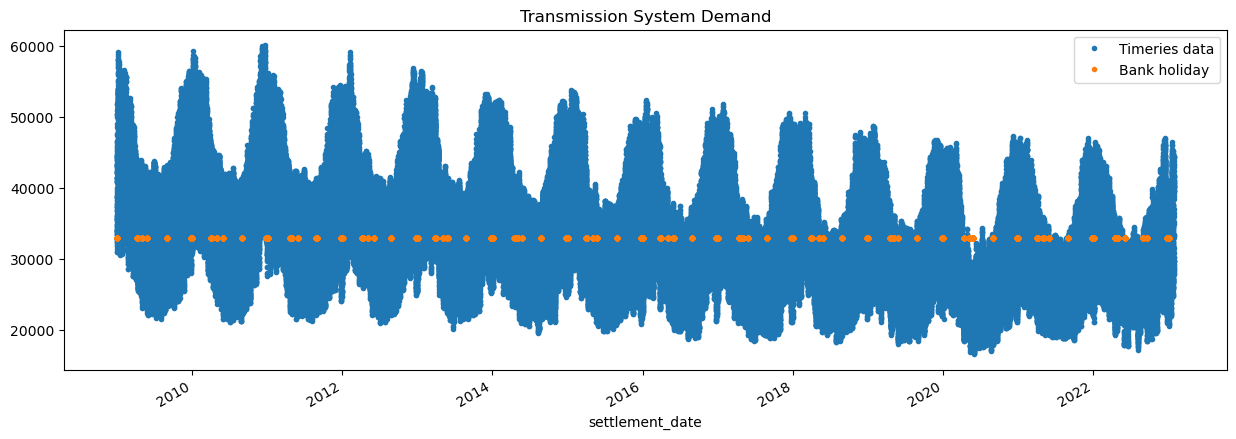

In [42]:
# Set date as the index and turn into datetime type
df_plot = df.copy()
df_plot = df_plot.set_index(df.index)
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Transmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

The graph below shows the distribution of Transmission System Demand in these 14 years. 

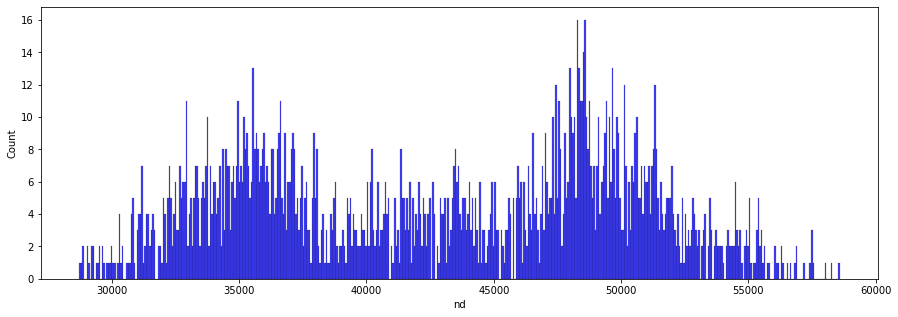

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=df, x="tsd", bins=500, ax=ax, color="b");

The graph shows that at the demand of electricity would peak at 17:00 to 18:00 throughout the 24 hours of the day, and the demand in the evening is generally higher than the other time period.

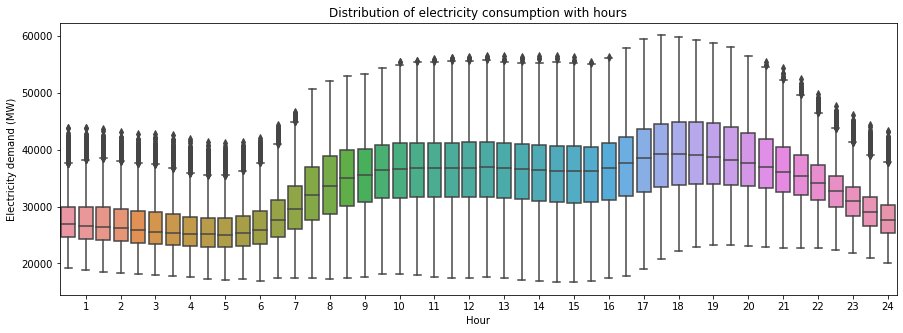

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=df)
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

The box plot compares the electricity demand on each day of the week between holiday and non-holiday. It shows that except for Saturday, the electricity demand would be lower than usual when it's holiday.

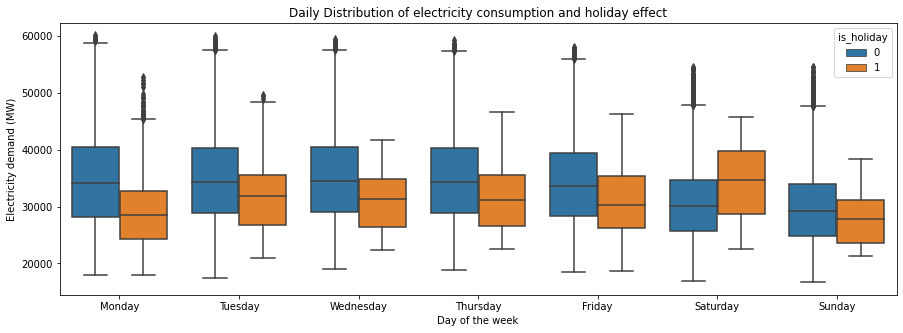

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, hue="is_holiday", ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect");

## **3. Data Preparation**

In this phase, we would create the feature of the time, which would be utilized in training and testing the model. The create_time() function could be used to separate the dimension of the time in different columns. The reason why the time periods are being used as features is mainly because according to the finding in EDA, electricity demand shows strong seasonality that could be captured by the time features such as the increasing demand in the winter because of people using heaters. Furthermore, referring to the trend of the demand, the decreaseing demand over the years could also be a strong evidence that should take year into account when predicting the model.

### 3.1 Feature engineering 

Next, due to the limitation of computational power, we select the data from the past five years, from January 26th 2018 to January 26th 2023. Additionally, in order to have the model converge in a faster speed, we scale the numerical variables from 0 to 1 using MinMaxscaler.

In [46]:
#separate the time dimension
def create_time(df):
    """
    Create time series features based on time series index

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with new features
    """
    df = df.copy()
    df["day_of_month"] = df.index.day
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    return df


In [47]:
df=df.loc[(df.index >= "2018-01-26") & (df.index <= "2023-01-26")]

In [48]:
scaler = MinMaxScaler(feature_range=(0, 1))
need_scale=['embedded_wind_generation', 'embedded_wind_capacity','embedded_solar_generation', 'embedded_solar_capacity', "tsd"]
for i in need_scale:
    df[i] = scaler.fit_transform(df[i].values.reshape(-1, 1))

In [49]:
df = create_time(df)

### 3.2 Data splitting and reshaping

In this section, data would be split into threee sets for training, validation and tetsing the model. In addition, to meet the requirement of the data shape of the neural network, the data would also be reshaped to tailor the need of the neural network models.

#### 3.2.1 Data splitting

Based on the exploratory data analysis, we could tell that the cycle of the demand is approximately a year. Therefore, we sequentially select 60% (3 years) of the data as training set, and 20% (1 year) each for the validation and test set, which can be seen in the visualization below.

In [50]:
threshold_date_1 = "2021-01-26"
threshold_date_2 = "2022-01-26"
train_data = df.loc[df.index < threshold_date_1]
val_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
test_data = df.loc[df.index >= threshold_date_2]

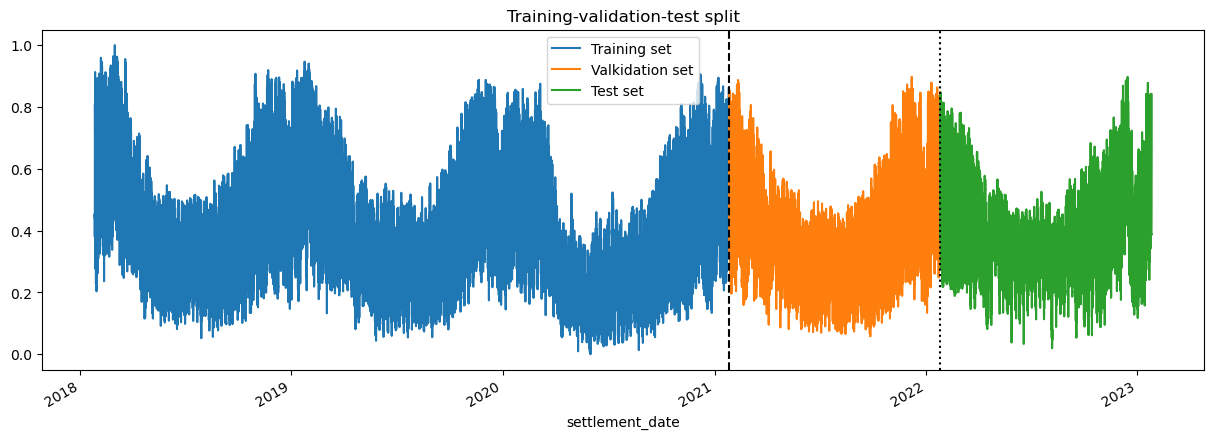

In [51]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["tsd"].plot(ax=ax, label="Training set")
val_data["tsd"].plot(ax=ax, label="Valkidation set")
test_data["tsd"].plot(ax=ax, label="Test set")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Training-validation-test split")
plt.legend();

#### 3.2.2 Data preparation for neural network

In order to meet the requirement of the data shape for the model predict the future 30 days' demand, the two functions are defined as below to reshape, split, and adding the time lag on y.

In [52]:
#define the function to reshape and concatenate all the variables
def reshape_and_concatenate(df, columns):
    reshaped = []
    for column in columns:
        reshaped_column = np.array(df[column].tolist())
        reshaped_column = reshaped_column.reshape((len(reshaped_column), 1))
        reshaped.append(reshaped_column)
    concatenated = np.hstack(reshaped)
    return concatenated

In [132]:
#define the function to split the reshaped data to X and y and adding the time lag on y to predict the future 30 days demand
#30 days time 48 data points a day equals to 1440, therefore the time lag is 1440.
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix + 1440 > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix+1440-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
##from len(sequence)-1140 not used to train any more

**Training set:**

The reason of setting up the time step is to utilize the features in the previous time periods for prediction, and in this case, the time step is set at 48 since the electricity demand follows a pattern in a day which forms a completed cycle.

In [63]:
columns = [
    "is_holiday", "settlement_period", "day_of_month", "day_of_year", 
    "quarter", "month", "year", 'embedded_wind_generation', 'embedded_wind_capacity',
       'embedded_solar_generation', 'embedded_solar_capacity', "tsd"
]

In [64]:
dataset_train = reshape_and_concatenate(train_data, columns)

In [65]:
# choose a number of time steps
n_steps = 48
# convert into input/output
train_X, train_y = split_sequences(dataset_train, n_steps)

**Validation set:**

In [66]:
dataset_val = reshape_and_concatenate(val_data, columns)

In [67]:
val_X, val_y = split_sequences(dataset_val, n_steps)

**Test set:**

In [68]:
dataset_test = reshape_and_concatenate(test_data, columns)

In [69]:
test_X, test_y = split_sequences(dataset_test, n_steps)

In [71]:
n_features = train_X.shape[2]

## **4. Modeling**

In the modeling part, we have one emsemble machine learning algorithm, RandomForest, 2 basic neural network that are better at processing sequential data, RNN and LSTM, and lastly we would fine-tune the basic neural network that gives out better result to perform analysis.

### 4.1 RamdomForestModel

RandomForest model is one of the powerful emsemble learning model and is often being used in supervised learning in regression task. In this section, we would be using Gridsearch to find the optimal hyper-parameters for the RandomForest model. The hyperparameters and the number included is decided based on the prior knowledge and the size of the dataset. Considering that Gridsearch could take up large computational power, we only search 2 numbers in each hyper parameters, and the number is limited to avoid overfitting.

The best hyper-parameters is:
{'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 300}

In [223]:
FEATURES = [
    "is_holiday", "settlement_period", "day_of_month", "day_of_year", 
    "quarter", "month", "year", 'embedded_wind_generation', 'embedded_wind_capacity',
       'embedded_solar_generation', 'embedded_solar_capacity'
]

TARGET = "tsd"

In [224]:
#the validating process is already in the grid search, therefore to keep the proportion of the trianing, validation and test set the same, here we merge the traing set and validation set together
X_train_rf= pd.concat([train_data[FEATURES], val_data[FEATURES]], axis=0)
y_train_rf= pd.concat([train_data[TARGET], val_data[TARGET]], axis=0)
X_test_rf=test_data[FEATURES]
y_test_rf= test_data[TARGET]

In [253]:
X_train_rf_lag=X_train_rf.iloc[:-1440, :] #creating time lag for reandom forest model

In [254]:
X_train_rf_lag=X_train_rf_lag.reset_index()
X_train_rf_lag=X_train_rf_lag.drop("settlement_date", axis=1)
X_train_rf_lag

,is_holiday,settlement_period,day_of_month,day_of_year,quarter,month,year,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity
0,0,1,26,26,1,1,2018,0.152065,0.000000,0.0,0.000000
1,0,2,26,26,1,1,2018,0.152065,0.000000,0.0,0.000000
2,0,3,26,26,1,1,2018,0.153609,0.000000,0.0,0.000000
3,0,4,26,26,1,1,2018,0.155152,0.000000,0.0,0.000000
4,0,5,26,26,1,1,2018,0.155345,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
68675,0,44,26,360,4,12,2021,0.211501,0.940881,0.0,0.173545
68676,0,45,26,360,4,12,2021,0.206677,0.940881,0.0,0.173545
68677,0,46,26,360,4,12,2021,0.201660,0.940881,0.0,0.173545
68678,0,47,26,360,4,12,2021,0.198186,0.940881,0.0,0.173545


In [244]:
y_train_rf_lag=y_train_rf[1440:]

In [ ]:
y_train_rf_lag

In [258]:
X_test_rf_lag=X_test_rf.iloc[:-1440, :]
X_test_rf_lag=X_test_rf_lag.reset_index()
X_test_rf_lag=X_test_rf_lag.drop("settlement_date", axis=1)
X_test_rf_lag

,is_holiday,settlement_period,day_of_month,day_of_year,quarter,month,year,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity
0,0,1,26,26,1,1,2022,0.217291,0.940881,0.0,0.819048
1,0,2,26,26,1,1,2022,0.221343,0.940881,0.0,0.819048
2,0,3,26,26,1,1,2022,0.228097,0.940881,0.0,0.819048
3,0,4,26,26,1,1,2022,0.234851,0.940881,0.0,0.819048
4,0,5,26,26,1,1,2022,0.240641,0.940881,0.0,0.819048
...,...,...,...,...,...,...,...,...,...,...,...
16074,0,45,26,360,4,12,2022,0.365496,0.963522,0.0,1.000000
16075,0,46,26,360,4,12,2022,0.354303,0.963522,0.0,1.000000
16076,0,47,26,360,4,12,2022,0.343883,0.963522,0.0,1.000000
16077,0,48,26,360,4,12,2022,0.333269,0.963522,0.0,1.000000


In [259]:
y_test_rf_lag=y_test_rf[1440:]

In [263]:
y_test_rf_lag

settlement_date
2022-02-25 00:00:00    0.320257
2022-02-25 00:30:00    0.326231
2022-02-25 01:00:00    0.310486
2022-02-25 01:30:00    0.297596
2022-02-25 02:00:00    0.288355
                         ...   
2023-01-25 22:00:00    0.538803
2023-01-25 22:30:00    0.485094
2023-01-25 23:00:00    0.419200
2023-01-25 23:30:00    0.386062
2023-01-26 00:00:00    0.387975
Name: tsd, Length: 16079, dtype: float64

In [257]:
param_grid = {
    "n_estimators" : [300, 500], #number of trees in the forest
    "max_depth" : [7, 10],  #maximum number of levels in each decision tree
    "min_samples_split" : [10, 15],  #minimum number of data points placed in a node before the node is split
    "min_samples_leaf" : [6, 10]  #minimum number of data points alowed in a lead node 
}

tscv = TimeSeriesSplit(n_splits=4) # same percaentage as nn 20(validation)/80(training) the left 20 is in the test set
rf = RandomForestRegressor(n_jobs=-1)
grid_search = GridSearchCV(rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv)
grid_search.fit(X_train_rf_lag, y_train_rf_lag)

rf_grid = GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid = param_grid, scoring = 'neg_mean_squared_error', cv =tscv)

# Fitting the RF model:
rf_grid.fit(X_train_rf, y_train_rf)

# The best parameters are: 
print(rf_grid.best_params_)

{'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 300}


In [260]:
# Choose the best hyperparameters
best_params_rf = rf_grid.best_params_

# Retrain the model on the entire time series using the best hyperparameters
rf = RandomForestRegressor(**best_params_rf)
rf.fit(X_train_rf_lag, y_train_rf_lag)

RandomForestRegressor(max_depth=10, min_samples_leaf=10, min_samples_split=15,
                      n_estimators=300)

#### 4.1.1 RandomForest Evaluation

The evaluation metric is set as rmse, since it penalizes the larger error more just like mse, but it's measured in the same scale as the original data for intuitive interpretation. The rmse for RandomForest on test set is 3277.06. 

In [261]:
# Evaluate the final model on a holdout dataset
y_pred_test_rf = np.array(rf.predict(X_test_rf_lag))
y_test_rf_ar= np.array(y_test_rf_lag)
y_test_rf_eval=y_test_rf_ar.reshape(-1,1)
y_pred_test_rf=y_pred_test_rf.reshape(-1,1)
unscaled_data_y_test_rf = scaler.inverse_transform(y_test_rf_eval)
unscaled_data_y_pred_rf = scaler.inverse_transform(y_pred_test_rf)
rmse_rf= np.sqrt(np.mean((unscaled_data_y_test_rf - unscaled_data_y_pred_rf)**2))
print(f"RMSE on test dataset: {rmse_rf}")

RMSE on test dataset: 3277.059364626063


#### 4.1.2 Comparison-Full Test set and Prediction

In addition, to illustrate the difference between the actual value and predictioneven clearer, the visualization is shown below in the comparison section.

In [267]:
begin="2022-02-25 23:30:00"
end= "2023-01-26 00:00:00" #set the time frame according to the time lag in neural network
result_frame = y_test_rf.to_frame()
result_frame=result_frame.loc[(result_frame.index >= begin) & (result_frame.index <= end)]
result_frame["random_forest_tuned_pred"]= y_pred_test_rf [47:] # because of the time step in Neural network, slice to unify the dimension of the data

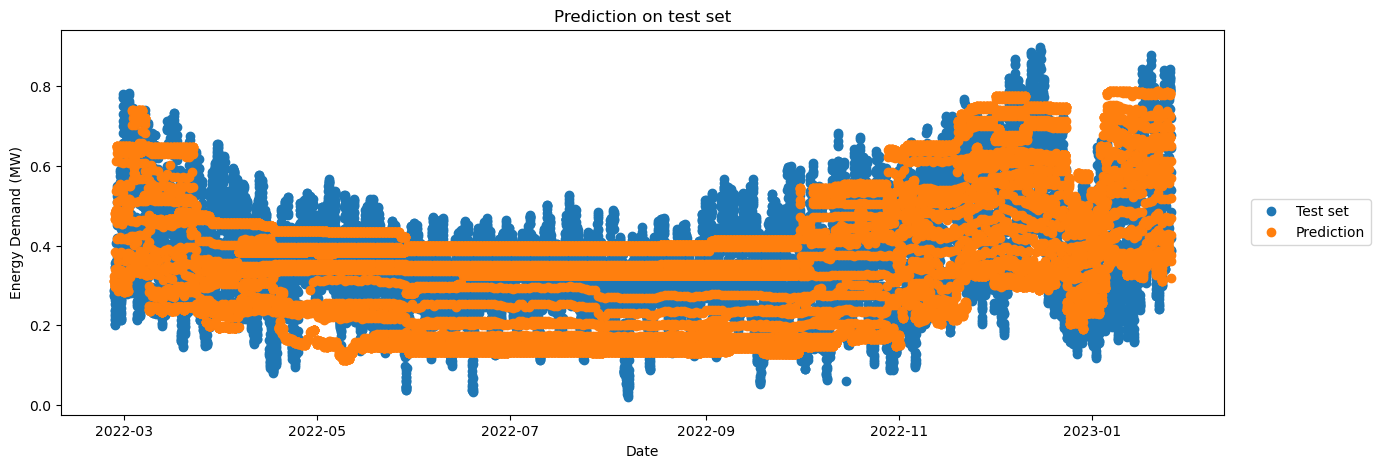

In [269]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["random_forest_tuned_pred"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

#### 4.1.3 Granular level  prediction comparison for one week

The graph shows the discrepency of one week prediction and the actual demand on test set from January 1st 2023 to January 8th 2023.

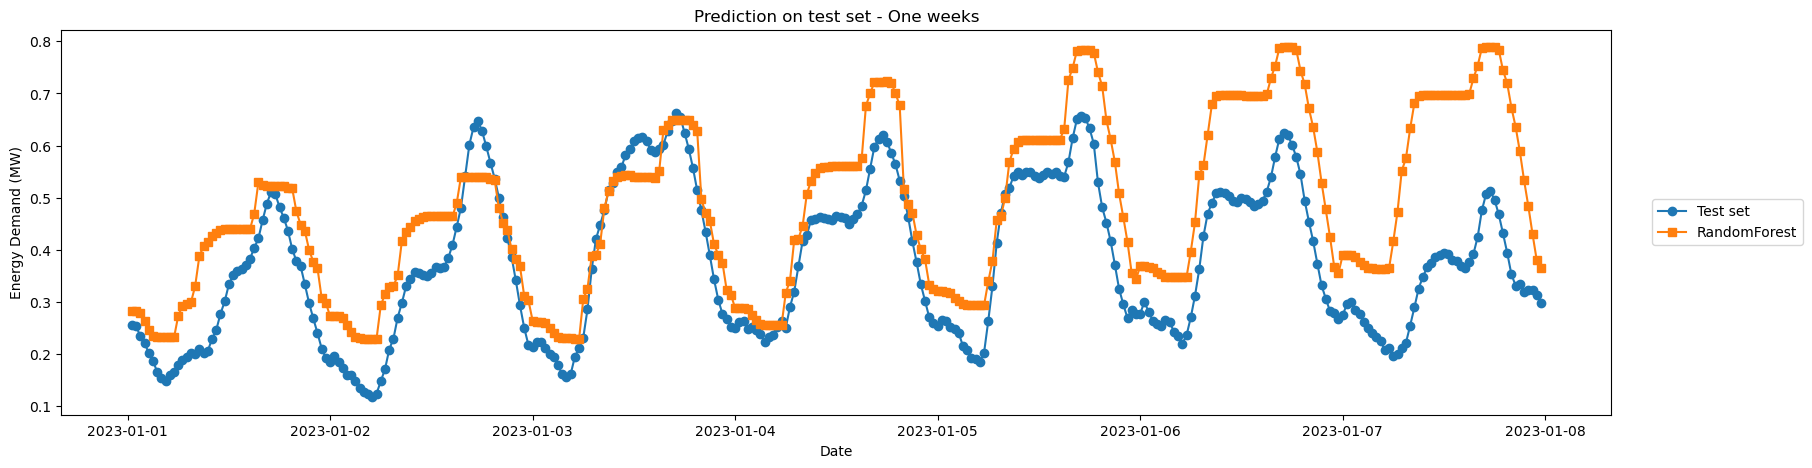

In [270]:
begin = "2023-01-01"
end = "2023-01-08"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o", label="Test set")

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["random_forest_tuned_pred"],
    "-s", label="RandomForest")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - One weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

### 4.2 RNN

Recurrent Neural Networks(RNN) are designed to handle sequential data due to its nature of remembering previous inputs, the capability of capturing short-term dependencies and non-linear relationships between variables, which could all be beneficial to future predictions. In this section, RNN is designed as one of the baseline model including only one hidden layer with 64 neurons with the default value of the hyper-parameters to be chosen from to perform the hyper-parameter tuning task.

In [73]:
checkpoint_rnn = ModelCheckpoint('rnn_model.h5', monitor='val_loss', save_best_only=True)
# Define the model architecture
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=64, activation='tanh', input_shape=(n_steps, n_features)))
model_rnn.add(Dense(units=1, activation='linear'))

# Compile the model
model_rnn.compile(loss='mean_squared_error', optimizer='adam')

# Print a summary of the model architecture
model_rnn.summary()

Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4864      
                                                                 
 dense_102 (Dense)           (None, 1)                 65        
                                                                 
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [74]:
history_rnn = model_rnn.fit(train_X, train_y, epochs=10, batch_size=50, validation_data=(val_X, val_y), verbose=2, shuffle=False, callbacks=[checkpoint_rnn])

Epoch 1/10
1023/1023 - 11s - loss: 0.0254 - val_loss: 0.0480 - 11s/epoch - 11ms/step
Epoch 2/10
1023/1023 - 10s - loss: 0.0270 - val_loss: 0.0411 - 10s/epoch - 10ms/step
Epoch 3/10
1023/1023 - 10s - loss: 0.0271 - val_loss: 0.0409 - 10s/epoch - 10ms/step
Epoch 4/10
1023/1023 - 10s - loss: 0.0271 - val_loss: 0.0408 - 10s/epoch - 10ms/step
Epoch 5/10
1023/1023 - 10s - loss: 0.0271 - val_loss: 0.0408 - 10s/epoch - 10ms/step
Epoch 6/10
1023/1023 - 10s - loss: 0.0271 - val_loss: 0.0408 - 10s/epoch - 10ms/step
Epoch 7/10
1023/1023 - 10s - loss: 0.0271 - val_loss: 0.0408 - 10s/epoch - 10ms/step
Epoch 8/10
1023/1023 - 10s - loss: 0.0271 - val_loss: 0.1008 - 10s/epoch - 10ms/step
Epoch 9/10
1023/1023 - 11s - loss: 0.0250 - val_loss: 0.0755 - 11s/epoch - 10ms/step
Epoch 10/10
1023/1023 - 10s - loss: 0.0267 - val_loss: 0.0407 - 10s/epoch - 10ms/step


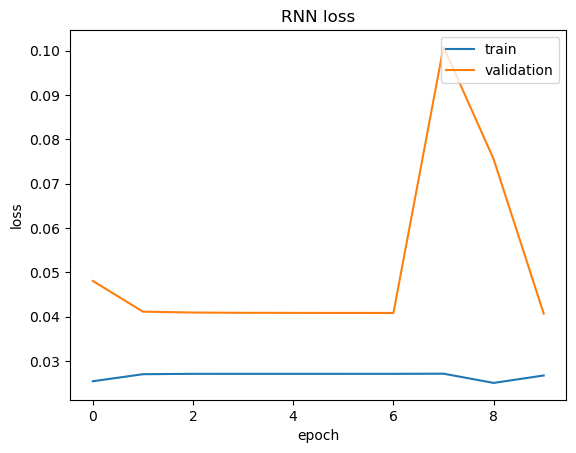

In [75]:
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('RNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

#### 4.2.1 RNN Evaluation

The rmse for RNN is about 6237, which means that on average the predictions made by the model deviates approximately 6237 MW from the actual values. This means that the basic RNN's forecasting accuracy is moderate compared to the tuned RandomForest. One possible reason could simply because the model is over simplified with only one layer and 10 epochs.

In [79]:
y_pred_rnn= model_rnn.predict(test_X, verbose=0)
test_y_eval=test_y.reshape(-1,1)
unscaled_data_y_test = scaler.inverse_transform(test_y_eval)
unscaled_data_y_pred_rnn = scaler.inverse_transform(y_pred_rnn)
rmse_rnn= np.sqrt(np.mean((unscaled_data_y_test - unscaled_data_y_pred_rnn)**2))
print(rmse_rnn)

6237.194090494953


In [264]:
len(y_pred_rnn)

16032

#### 4.2.2 Comparison-Full Test set and Prediction

According to the result below, it seems that the basic rnn model couldn't identify the underlying pattern in the data, making it predicting a constant line through the prediction.

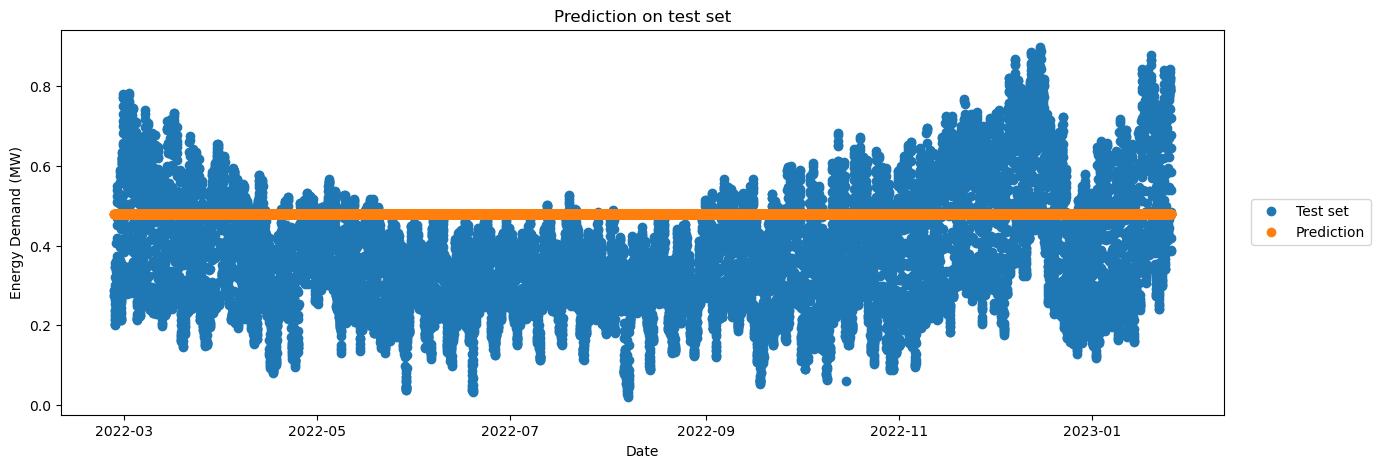

In [100]:
result_frame["rnn"]= y_pred_rnn
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["rnn"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

#### 4.2.3 Granular level  prediction comparison for 1 week

Examining the performance of the model on the granular level, the same case still holds, proving that the model is not capable of capturing the pattern.

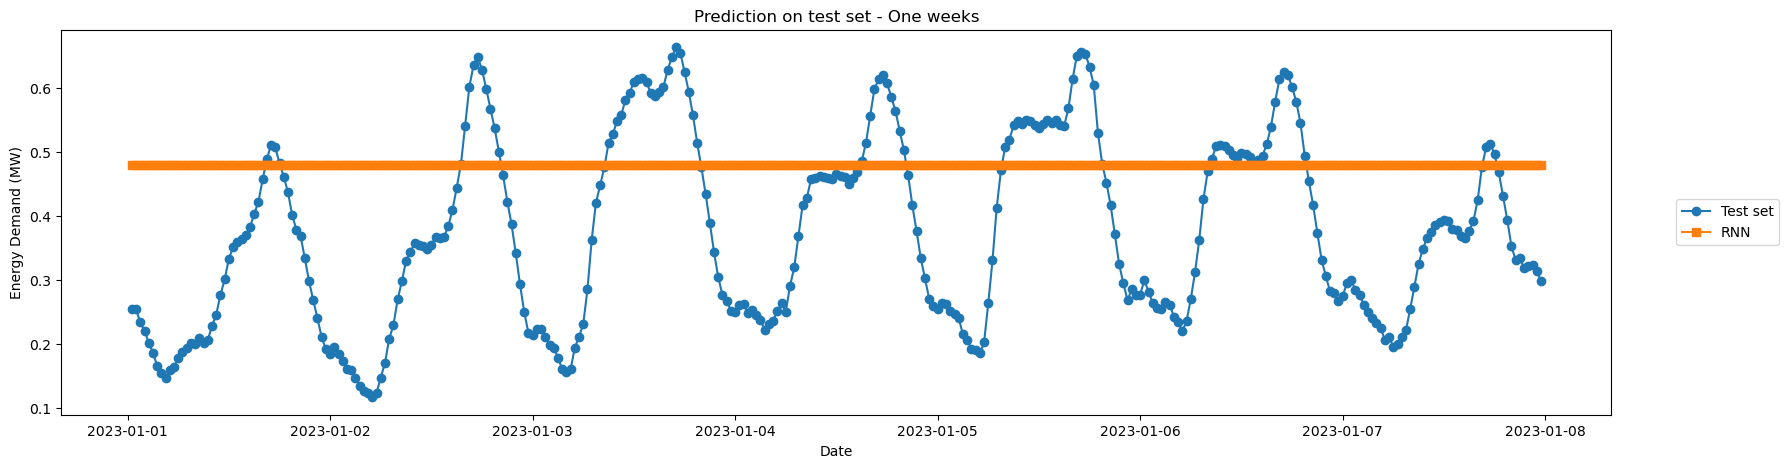

In [101]:
begin = "2023-01-01"
end = "2023-01-08"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o", label="Test set")

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["rnn"],
    "-s", label="RNN")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - One weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

### 4.3 Baseline Model LSTM

Long Short-Term Memory Network (LSTM) is a type of neural networks that is designed on the basis of RNN for time-series data forecasting. Not only could LSTM addresses the issue of vanishing and exploding gradients by the gating mechanisms to control the information flows through the network, but it also has the capability of capturing long-term dependencies in the cell state compared to RNN, which could be used to identify the pattern of the features throughout the time.

In [102]:
# define model
checkpoint = ModelCheckpoint('best_base_model.h5', monitor='val_loss', save_best_only=True)
base_model = Sequential()
base_model.add(LSTM(units=50, activation='sigmoid', input_shape=(n_steps, n_features)))
base_model.add(Dense(1))
optimizer = Adam(learning_rate=0.00001, clipnorm=1.0)
base_model.compile(optimizer= optimizer, loss='mse')
base_model.summary()

Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_304 (LSTM)             (None, 50)                12400     
                                                                 
 dense_103 (Dense)           (None, 1)                 51        
                                                                 
Total params: 12,451
Trainable params: 12,451
Non-trainable params: 0
_________________________________________________________________


In [104]:
history = base_model.fit(train_X, train_y, epochs=10, batch_size=50, validation_data=(val_X, val_y), verbose=1, shuffle=False, callbacks=[checkpoint])

Epoch 1/10
1023/1023 [==============================] - 30s 29ms/step - loss: 0.4210 - val_loss: 0.2453
Epoch 2/10
1023/1023 [==============================] - 29s 29ms/step - loss: 0.1761 - val_loss: 0.0846
Epoch 3/10
1023/1023 [==============================] - 29s 29ms/step - loss: 0.0651 - val_loss: 0.0349
Epoch 4/10
1023/1023 [==============================] - 29s 28ms/step - loss: 0.0414 - val_loss: 0.0292
Epoch 5/10
1023/1023 [==============================] - 29s 28ms/step - loss: 0.0380 - val_loss: 0.0288
Epoch 6/10
1023/1023 [==============================] - 29s 28ms/step - loss: 0.0375 - val_loss: 0.0289
Epoch 7/10
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0374 - val_loss: 0.0289
Epoch 8/10
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0374 - val_loss: 0.0289
Epoch 9/10
1023/1023 [==============================] - 28s 28ms/step - loss: 0.0374 - val_loss: 0.0289
Epoch 10/10
1023/1023 [==============================] - 28s 28m

The plot below shows the validation loss for the model throughout the epochs. It seems that toward the end of the training process, the training and validation loss starts to flatten. One possible explanation could be the model has converged and is no longer improving. In other words, the model has found the optimal set of parameters to minimize the loss function.

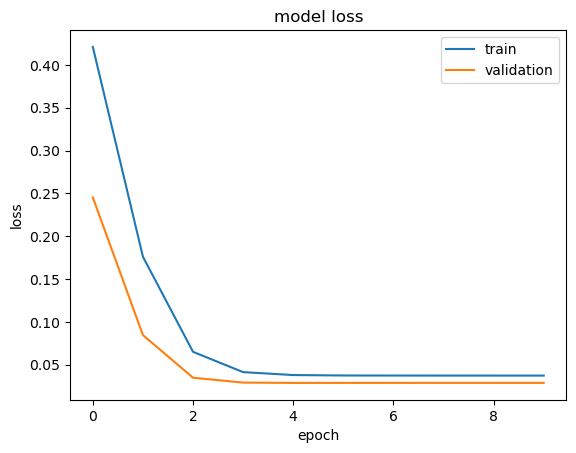

In [105]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

#### 4.3.1 LSTM Evaluation

The rmse of the LSTM baseline model is lower than the RNN base line model by approximately 1200, which is a substential improvement of 20%, considering the fact that the mean of the demand is about 33000.

In [138]:
y_pred_lstm_base = base_model.predict(test_X, verbose=0)
unscaled_data_y_pred_lstm_base = scaler.inverse_transform(y_pred_lstm_base)
rmse_lstm_base= np.sqrt(np.mean((unscaled_data_y_test - unscaled_data_y_pred_lstm_base)**2))
print(rmse_lstm_base)


5061.759669295356


#### 4.3.2 Comparison-Full Test set and Prediction

The result below clearly shows the result of LSTM model prediction. Different from RNN, LSTM could start telling the underlying pattern in the data, and start making relatively valid prediction.

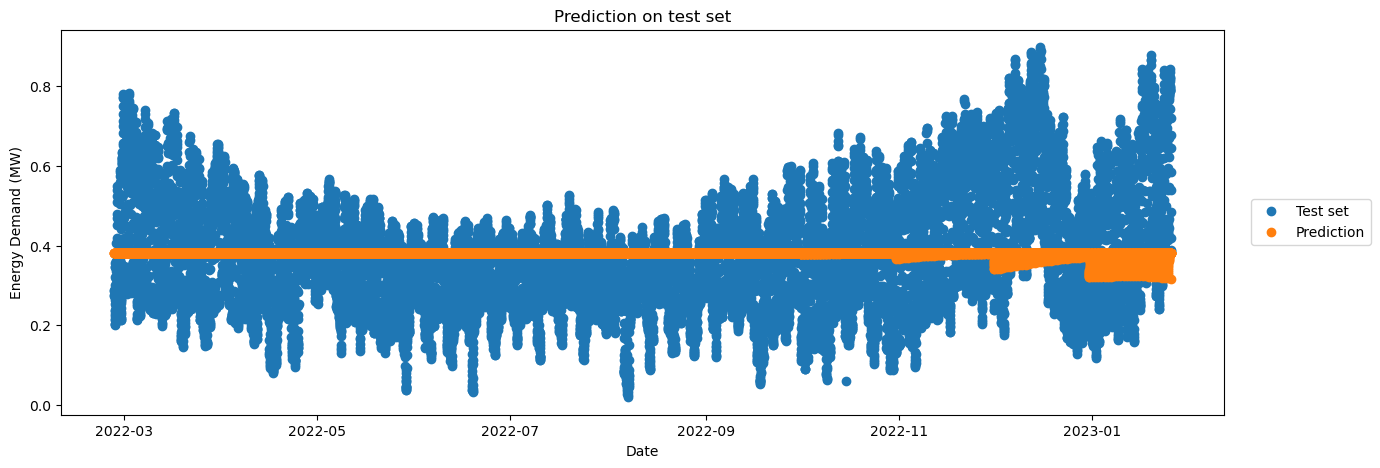

In [139]:
result_frame["lstm_base"]= y_pred_lstm_base
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["lstm_base"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

#### 4.3.3 Granular level  prediction comparison for 1 week

The result below shows that the model could identify the the trend and the cycle of the data in a certain degree. Although it's not perfectly fit to the distribution, but it's confident to say that LSTM is more suitable at predicting time-series data than RNN.

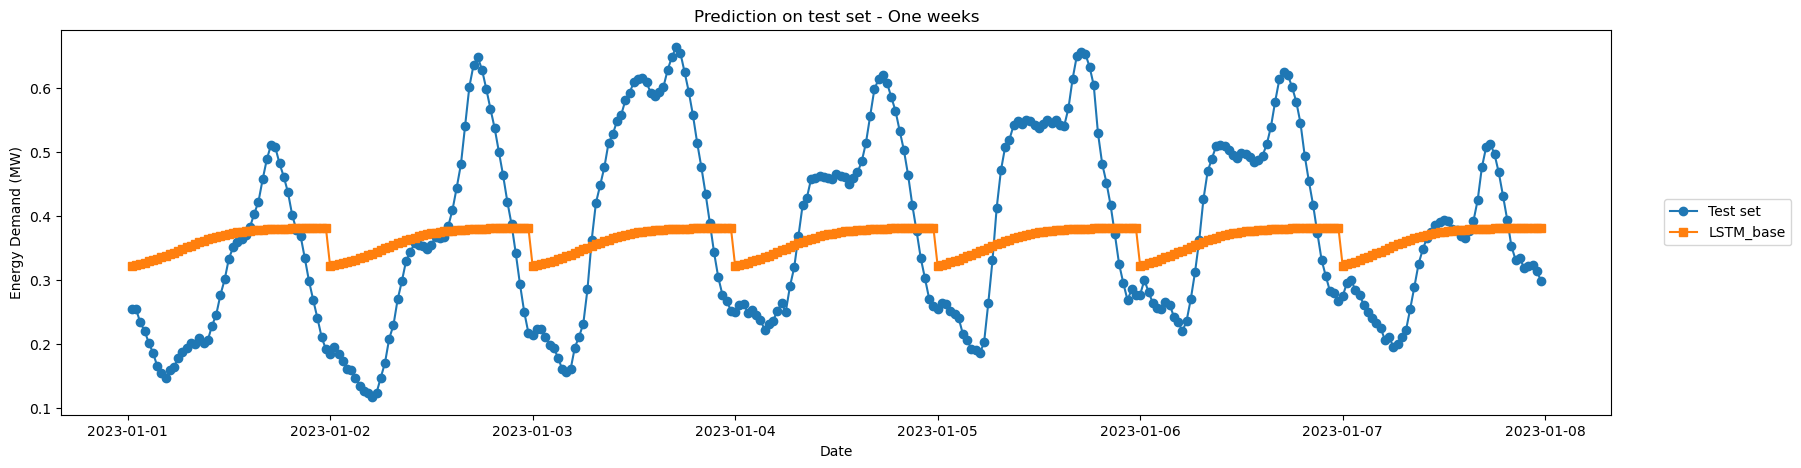

In [140]:
begin = "2023-01-01"
end = "2023-01-08"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o", label="Test set")

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["lstm_base"],
    "-s", label="LSTM_base")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - One weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

### 4.4 Fine_tuned LSTM

Based on the findings that LSTM performs better than RNN, LSTM is chosen to be fine-tuned with different parameters, including activation function and the number of neurons in each hidden layer. The chosen number in the Gridsearch is based on the size of the dataset and the prior knowledge to neural network. In the training, we use tscv to avoid random selection of the validation set while performing the Gridsearch, and apply the early stopping to prevent overfitting issue.

In [112]:
# Wrap the model into a function for the Keras Regressor
def tuned_lstm(learning_rate=0.01, activation_function='linear', lm_unit_1=50, lm_unit_2=50, lm_unit_3=50):
    tuned = tf.keras.Sequential()
    tuned.add(LSTM(units=lm_unit_1, activation= activation_function, input_shape=(n_steps, n_features),return_sequences=True))
    tuned.add(LSTM(units=lm_unit_2, activation= activation_function, return_sequences=True))
    tuned.add(LSTM(units=lm_unit_3, activation= activation_function))
    tuned.add(Dense(units=1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    tuned.compile(optimizer= optimizer, loss='mse')
    return tuned

Towards the end of the Gridsearch, we could find that training and validation loss are in a extremely large number, considering the fact that the electricity demand is already scaled. There might be two possible explanations. Firstly, as the depth of the network and the number of neurons increase, the gradients can become larger as they propagate through the layers, while updating the weight using backpropagation. Furthermore, certain activation functions, such as the sigmoid, can saturate large inputs, which could be causing the gradients to become extremely large.

Best Parameters:  {'activation_function': 'sigmoid', 'batch_size': 50, 'epochs': 10, 'learning_rate': 0.001, 'lm_unit_1': 100, 'lm_unit_2': 100, 'lm_unit_3': 50}

In [113]:
# Define the hyperparameter grid to search over
# We will tune 4 hyperparameters: activation function, number of neurons in each hidden layer
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {
    'batch_size': [50],
    'epochs':[10],
    'learning_rate': [0.001],
    'activation_function': ['sigmoid','relu'],
    'lm_unit_1':[50,100],
    'lm_unit_2':[50,100],
    'lm_unit_3':[50,100]
}

# Wrap the model for preparing Grridsearch
lstm_estimator = KerasRegressor(build_fn= tuned_lstm, verbose=1)

# Set up early stopping callback in patience 3 to avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Perform grid search over the hyperparameter grid
grid_search = GridSearchCV(estimator=lstm_estimator, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_result = grid_search.fit(train_X, train_y, callbacks=[early_stop], validation_data=(val_X, val_y), verbose=2)

# Print the best parameters and the nmse
print("Best Parameters: ", grid_result.best_params_)
print("Validation Accuracy: ", grid_result.best_score_)

/tmp/ipykernel_122836/2176413792.py:15: DeprecationWarning:

KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.



Epoch 1/10
256/256 - 25s - loss: 0.0235 - val_loss: 0.0172 - 25s/epoch - 98ms/step
Epoch 2/10
256/256 - 22s - loss: 0.0142 - val_loss: 0.0178 - 22s/epoch - 88ms/step
Epoch 3/10
256/256 - 23s - loss: 0.0123 - val_loss: 0.0158 - 23s/epoch - 89ms/step
Epoch 4/10
256/256 - 21s - loss: 0.0123 - val_loss: 0.0141 - 21s/epoch - 83ms/step
Epoch 5/10
256/256 - 21s - loss: 0.0121 - val_loss: 0.0176 - 21s/epoch - 82ms/step
Epoch 6/10
256/256 - 21s - loss: 0.0116 - val_loss: 0.0169 - 21s/epoch - 83ms/step
Epoch 7/10
256/256 - 21s - loss: 0.0116 - val_loss: 0.0159 - 21s/epoch - 83ms/step
256/256 [==============================] - 4s 16ms/step
Epoch 1/10
512/512 - 42s - loss: 0.0416 - val_loss: 0.0260 - 42s/epoch - 82ms/step
Epoch 2/10
512/512 - 37s - loss: 0.0312 - val_loss: 0.0227 - 37s/epoch - 73ms/step
Epoch 3/10
512/512 - 36s - loss: 0.0292 - val_loss: 0.0232 - 36s/epoch - 71ms/step
Epoch 4/10
512/512 - 36s - loss: 0.0271 - val_loss: 0.0286 - 36s/epoch - 71ms/step
Epoch 5/10
512/512 - 36s - loss

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages

Epoch 1/10
512/512 - 47s - loss: nan - val_loss: nan - 47s/epoch - 92ms/step
Epoch 2/10
512/512 - 41s - loss: nan - val_loss: nan - 41s/epoch - 81ms/step
Epoch 3/10
512/512 - 41s - loss: nan - val_loss: nan - 41s/epoch - 79ms/step
256/256 [==============================] - 5s 19ms/step


/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages

Epoch 1/10
767/767 - 70s - loss: 773958784.0000 - val_loss: 58849256.0000 - 70s/epoch - 91ms/step
Epoch 2/10
767/767 - 68s - loss: 108092000.0000 - val_loss: 1777063.8750 - 68s/epoch - 88ms/step
Epoch 3/10
767/767 - 65s - loss: 234817.2188 - val_loss: 135749.6875 - 65s/epoch - 84ms/step
Epoch 4/10
767/767 - 65s - loss: 147810.8125 - val_loss: 155272.4531 - 65s/epoch - 84ms/step
Epoch 5/10
767/767 - 64s - loss: 165150.1719 - val_loss: 120911.0938 - 64s/epoch - 84ms/step
Epoch 6/10
767/767 - 65s - loss: 102149.4453 - val_loss: 67357.0000 - 65s/epoch - 84ms/step
Epoch 7/10
767/767 - 64s - loss: 68480.9219 - val_loss: 45217.4062 - 64s/epoch - 84ms/step
Epoch 8/10
767/767 - 65s - loss: 42577.9180 - val_loss: 26857.3789 - 65s/epoch - 84ms/step
Epoch 9/10
767/767 - 64s - loss: 962631.1875 - val_loss: 9696.2520 - 64s/epoch - 84ms/step
Epoch 10/10
767/767 - 64s - loss: 9071.5791 - val_loss: 7237.1182 - 64s/epoch - 84ms/step
256/256 [==============================] - 6s 23ms/step
Epoch 1/10
256/

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages

Epoch 1/10
512/512 - 50s - loss: 29642624.0000 - val_loss: 7769072.0000 - 50s/epoch - 98ms/step
Epoch 2/10
512/512 - 47s - loss: 3682926.5000 - val_loss: 1577461.7500 - 47s/epoch - 92ms/step
Epoch 3/10
512/512 - 46s - loss: 3152975.5000 - val_loss: 1662937.5000 - 46s/epoch - 89ms/step
Epoch 4/10
512/512 - 45s - loss: 1072506.8750 - val_loss: 203177.5312 - 45s/epoch - 89ms/step
Epoch 5/10
512/512 - 46s - loss: 468827.4688 - val_loss: 617.4962 - 46s/epoch - 89ms/step
Epoch 6/10
512/512 - 45s - loss: 393.5636 - val_loss: 1867.4683 - 45s/epoch - 87ms/step
Epoch 7/10
512/512 - 45s - loss: 1242.5695 - val_loss: 1756.4077 - 45s/epoch - 89ms/step
Epoch 8/10
512/512 - 48s - loss: 3196.6409 - val_loss: 21552.6719 - 48s/epoch - 93ms/step
256/256 [==============================] - 7s 28ms/step
Epoch 1/10
767/767 - 81s - loss: nan - val_loss: nan - 81s/epoch - 106ms/step
Epoch 2/10
767/767 - 75s - loss: nan - val_loss: nan - 75s/epoch - 98ms/step
Epoch 3/10
767/767 - 74s - loss: nan - val_loss: nan

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages

Epoch 1/10
256/256 - 39s - loss: nan - val_loss: nan - 39s/epoch - 151ms/step
Epoch 2/10
256/256 - 35s - loss: nan - val_loss: nan - 35s/epoch - 137ms/step
Epoch 3/10
256/256 - 35s - loss: nan - val_loss: nan - 35s/epoch - 136ms/step
256/256 [==============================] - 8s 31ms/step


/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages

Epoch 1/10
512/512 - 66s - loss: 414495872.0000 - val_loss: 3471227.5000 - 66s/epoch - 130ms/step
Epoch 2/10
512/512 - 63s - loss: 16907390.0000 - val_loss: 6958922.5000 - 63s/epoch - 123ms/step
Epoch 3/10
512/512 - 63s - loss: 12200892.0000 - val_loss: 2030954.5000 - 63s/epoch - 124ms/step
Epoch 4/10
512/512 - 64s - loss: 2414646.0000 - val_loss: 521516.7500 - 64s/epoch - 124ms/step
Epoch 5/10
512/512 - 63s - loss: 1906742.1250 - val_loss: 1683468.0000 - 63s/epoch - 124ms/step
Epoch 6/10
512/512 - 63s - loss: 1165121.0000 - val_loss: 85891.3516 - 63s/epoch - 124ms/step
Epoch 7/10
512/512 - 64s - loss: 18088452.0000 - val_loss: 23805668.0000 - 64s/epoch - 125ms/step
Epoch 8/10
512/512 - 64s - loss: 1063430.3750 - val_loss: 518805.4062 - 64s/epoch - 124ms/step
Epoch 9/10
512/512 - 65s - loss: 9218702.0000 - val_loss: 75543648.0000 - 65s/epoch - 127ms/step
256/256 [==============================] - 9s 33ms/step
Epoch 1/10
767/767 - 94s - loss: 11192223.0000 - val_loss: 301885.6562 - 94s/

/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages

Epoch 1/10
256/256 - 39s - loss: nan - val_loss: nan - 39s/epoch - 153ms/step
Epoch 2/10
256/256 - 39s - loss: nan - val_loss: nan - 39s/epoch - 153ms/step
Epoch 3/10
256/256 - 43s - loss: nan - val_loss: nan - 43s/epoch - 167ms/step
256/256 [==============================] - 9s 36ms/step


/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages

Epoch 1/10
512/512 - 76s - loss: nan - val_loss: nan - 76s/epoch - 148ms/step
Epoch 2/10
512/512 - 70s - loss: nan - val_loss: nan - 70s/epoch - 137ms/step
Epoch 3/10
512/512 - 71s - loss: nan - val_loss: nan - 71s/epoch - 138ms/step
256/256 [==============================] - 10s 36ms/step


/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages

Epoch 1/10
767/767 - 108s - loss: nan - val_loss: nan - 108s/epoch - 141ms/step
Epoch 2/10
767/767 - 104s - loss: nan - val_loss: nan - 104s/epoch - 135ms/step
Epoch 3/10
767/767 - 103s - loss: nan - val_loss: nan - 103s/epoch - 135ms/step
256/256 [==============================] - 10s 36ms/step


/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning:

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/metrics/_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages

Epoch 1/10
1023/1023 - 121s - loss: 0.0358 - val_loss: 0.0229 - 121s/epoch - 119ms/step
Epoch 2/10
1023/1023 - 116s - loss: 0.0310 - val_loss: 0.0240 - 116s/epoch - 113ms/step
Epoch 3/10
1023/1023 - 116s - loss: 0.0281 - val_loss: 0.0209 - 116s/epoch - 113ms/step
Epoch 4/10
1023/1023 - 115s - loss: 0.0273 - val_loss: 0.0222 - 115s/epoch - 113ms/step
Epoch 5/10
1023/1023 - 115s - loss: 0.0268 - val_loss: 0.0213 - 115s/epoch - 113ms/step
Epoch 6/10
1023/1023 - 115s - loss: 0.0266 - val_loss: 0.0210 - 115s/epoch - 113ms/step
Best Parameters:  {'activation_function': 'sigmoid', 'batch_size': 50, 'epochs': 10, 'learning_rate': 0.001, 'lm_unit_1': 100, 'lm_unit_2': 100, 'lm_unit_3': 50}
Validation Accuracy:  -0.01841134801195405


In [137]:
# Get the best hyperparameters
best_params_LSTM = grid_result.best_params_

checkpoint_lstm_tuned = ModelCheckpoint('tuned_lstm_model.h5', monitor='val_loss', save_best_only=True)

# Create a new instance of the tuned LSTM model with the best hyperparameters
best_model_lstm = tuned_lstm(learning_rate=best_params_LSTM['learning_rate'], 
                             activation_function=best_params_LSTM['activation_function'], 
                             lm_unit_1=best_params_LSTM['lm_unit_1'],
                             lm_unit_2=best_params_LSTM['lm_unit_2'], 
                             lm_unit_3=best_params_LSTM['lm_unit_3'])

# Train the model on the full training set with the best hyperparameters
history = best_model_lstm.fit(train_X, train_y, 
                         epochs=best_params_LSTM['epochs'], 
                         batch_size=best_params_LSTM['batch_size'], 
                         validation_data=(val_X, val_y), 
                         callbacks=[early_stop, checkpoint_lstm_tuned])


Epoch 1/10
1023/1023 [==============================] - 125s 119ms/step - loss: 0.0299 - val_loss: 0.0187
Epoch 2/10
1023/1023 [==============================] - 121s 119ms/step - loss: 0.0221 - val_loss: 0.0162
Epoch 3/10
1023/1023 [==============================] - 121s 118ms/step - loss: 0.0193 - val_loss: 0.0136
Epoch 4/10
1023/1023 [==============================] - 120s 117ms/step - loss: 0.0175 - val_loss: 0.0141
Epoch 5/10
1023/1023 [==============================] - 120s 117ms/step - loss: 0.0156 - val_loss: 0.0111
Epoch 6/10
1023/1023 [==============================] - 120s 117ms/step - loss: 0.0113 - val_loss: 0.0101
Epoch 7/10
1023/1023 [==============================] - 119s 117ms/step - loss: 0.0102 - val_loss: 0.0136
Epoch 8/10
1023/1023 [==============================] - 120s 117ms/step - loss: 0.0095 - val_loss: 0.0091
Epoch 9/10
1023/1023 [==============================] - 121s 118ms/step - loss: 0.0093 - val_loss: 0.0095
Epoch 10/10
1023/1023 [=======================

#### 4.4.1 Tuned LSTM Evaluation

Compared to the untuned LSTM, the tuned model has come to a huge improvement. RMSE decreases over 700 MW of error, which is 14% better than the previous model.

In [220]:
y_pred_tuned = best_model_lstm.predict(test_X, verbose=1)
unscaled_data_y_pred_best = scaler.inverse_transform(y_pred_tuned)
rmse_tuned= np.sqrt(np.mean((unscaled_data_y_test - unscaled_data_y_pred_best)**2))
print(rmse_tuned)

501/501 [==============================] - 11s 22ms/step
4321.460505109668


#### 4.4.2 Comparison-Full Test set and Prediction

Observing the visualization presented, we could assure that tuned LSTM model is significantly better at capturing the pattern than all the previous model.

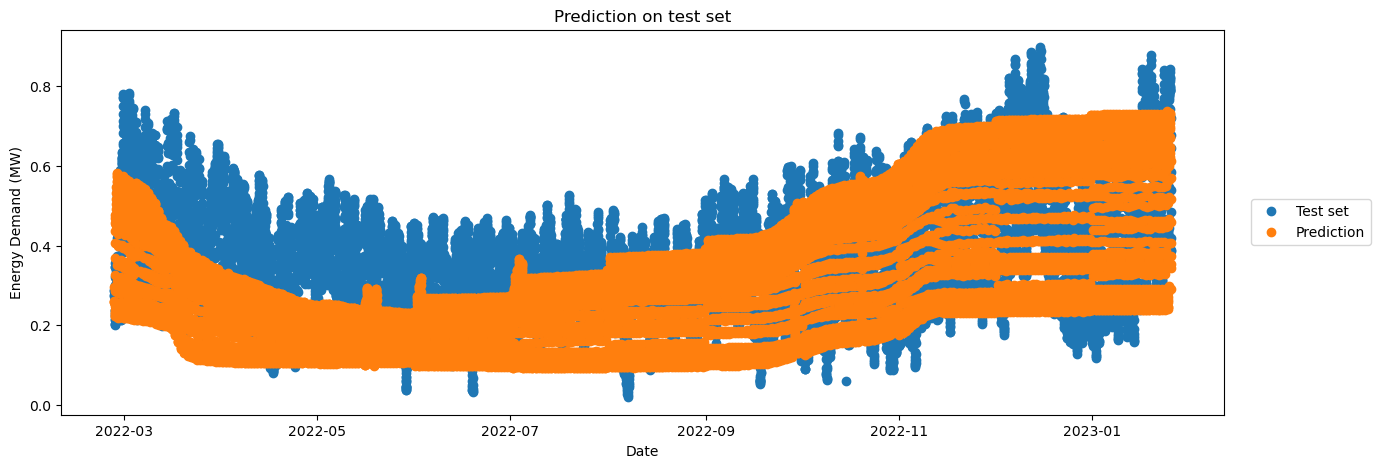

In [153]:
result_frame["lstm_tuned"]= y_pred_tuned
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["lstm_tuned"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

#### 4.4.3 Granular level  prediction comparison for 1 week

Examining on the weekly prediction, it's even more clear that LSTM has captured the seasonality pattern in the training process.

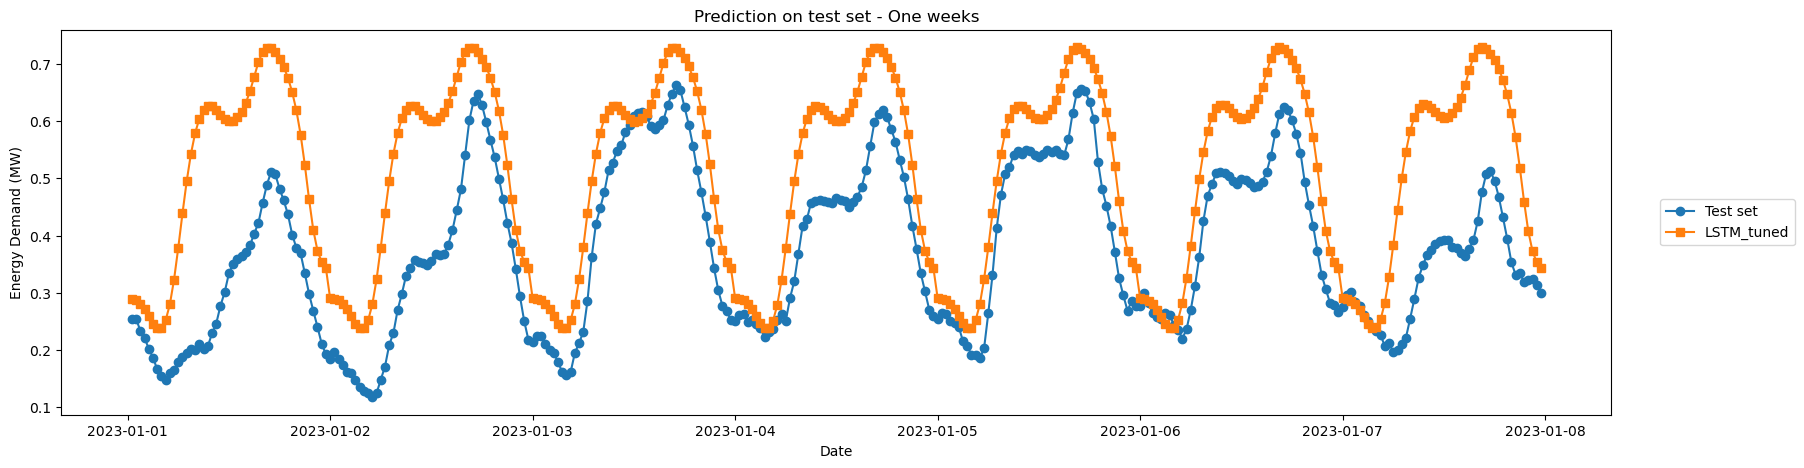

In [154]:
begin = "2023-01-01"
end = "2023-01-08"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o", label="Test set")

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["lstm_tuned"],
    "-s", label="LSTM_tuned")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - One weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

### 4.5 Fine_tuned LSTM with Learning rate schedule

Due to the limitation of computational power, we're not able to include different learning rate in the Gridsearch. However, we could adjust the current learning rate with the learning rate scheduler to slightly optimize the learning rate by applying the decay step and decay rate.

In [144]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=False)

checkpoint_scheduled_tuned = ModelCheckpoint('tuned_lstm_model_scheduled.h5', monitor='val_loss', save_best_only=True)

# Create a new instance of the tuned LSTM model with the best hyperparameters
best_model_lstm = tuned_lstm(learning_rate=lr_schedule, 
                             activation_function=best_params_LSTM['activation_function'], 
                             lm_unit_1=best_params_LSTM['lm_unit_1'],
                             lm_unit_2=best_params_LSTM['lm_unit_2'], 
                             lm_unit_3=best_params_LSTM['lm_unit_3'])

# Train the model on the full training set with the best hyperparameters
history = best_model_lstm.fit(train_X, train_y, 
                         epochs=20, 
                         batch_size=50, 
                         validation_data=(val_X, val_y), 
                         callbacks=[early_stop, checkpoint_scheduled_tuned])

Epoch 1/20
1023/1023 [==============================] - 124s 118ms/step - loss: 0.0312 - val_loss: 0.0184
Epoch 2/20
1023/1023 [==============================] - 121s 119ms/step - loss: 0.0220 - val_loss: 0.0195
Epoch 3/20
1023/1023 [==============================] - 120s 118ms/step - loss: 0.0202 - val_loss: 0.0152
Epoch 4/20
1023/1023 [==============================] - 119s 117ms/step - loss: 0.0189 - val_loss: 0.0148
Epoch 5/20
1023/1023 [==============================] - 119s 116ms/step - loss: 0.0180 - val_loss: 0.0138
Epoch 6/20
1023/1023 [==============================] - 119s 117ms/step - loss: 0.0173 - val_loss: 0.0146
Epoch 7/20
1023/1023 [==============================] - 120s 117ms/step - loss: 0.0156 - val_loss: 0.0120
Epoch 8/20
1023/1023 [==============================] - 120s 117ms/step - loss: 0.0119 - val_loss: 0.0091
Epoch 9/20
1023/1023 [==============================] - 121s 118ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 10/20
1023/1023 [=======================

In [147]:
scheduled_lstm=load_model("tuned_lstm_model_scheduled.h5")

#### 4.5.1 Scheduled LSTM Evaluation

After applying the learning rate scheduler, the rmse decrease by about 250, which is nearly 6% improvement of the tuned model.

In [148]:
y_pred_scheduled = scheduled_lstm.predict(test_X, verbose=1)
unscaled_data_y_pred_scheduled = scaler.inverse_transform(y_pred_scheduled)
rmse_scheduled= np.sqrt(np.mean((unscaled_data_y_test - unscaled_data_y_pred_scheduled)**2))
print(rmse_scheduled)

501/501 [==============================] - 12s 22ms/step
4078.0184877692977


#### 4.5.2 Comparison-Full Test set and Prediction

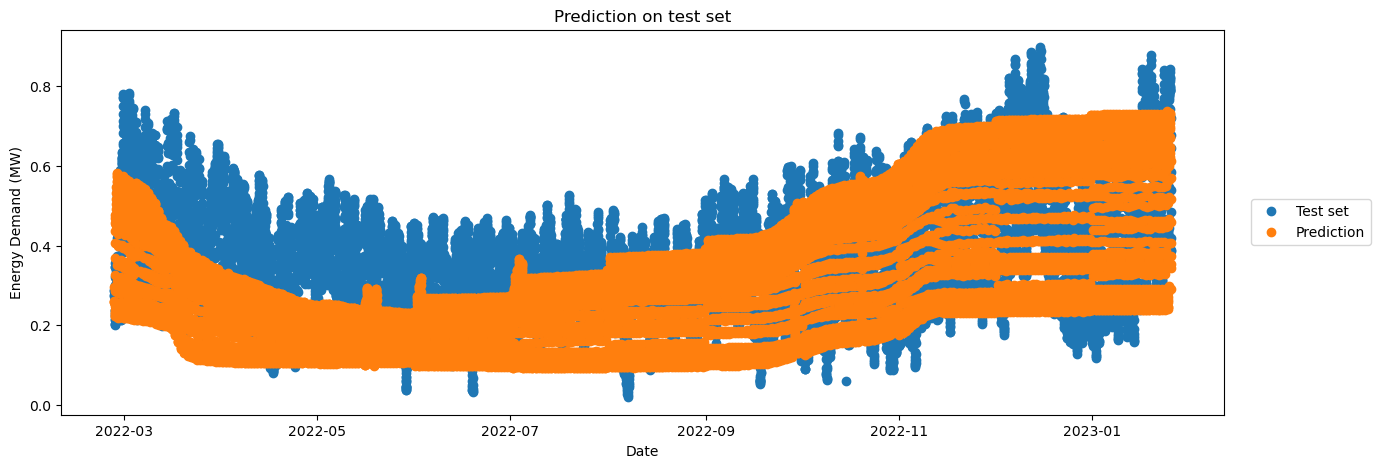

In [149]:
result_frame["lstm_scheduled"]= y_pred_scheduled
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["lstm_tuned"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

#### 4.5.3 Granular level  prediction comparison for 1 week

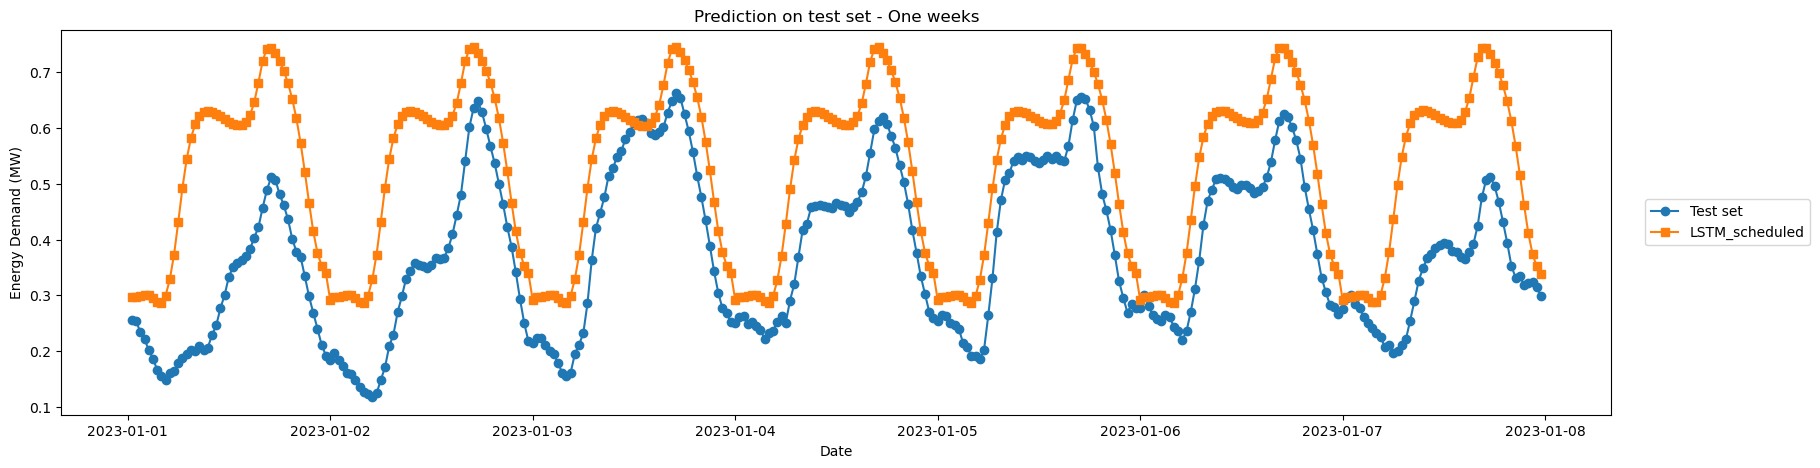

In [152]:
begin = "2023-01-01"
end = "2023-01-08"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o", label="Test set")

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["lstm_scheduled"],
    "-s", label="LSTM_scheduled")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - One weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

## **5. Result and Conclusion**

### 5.1 Future Prediction using scheduled LSTM

In [179]:
#create the index for future prediction
prediction_days = 30

future = pd.date_range(
    '2023-01-26 00:30:00',
    result_frame.index.max() + datetime.timedelta(days=prediction_days),
    freq="30min",
)

In [169]:
last_1440_test_X = test_X[-1440:] #retreive the last 1440 test_X that has not been used in testing the data

In [ ]:
# using the last 1440 data on the test set for future prediction
future_prediction=scheduled_lstm.predict(last_1440_test_X, verbose=1) 

In [ ]:
prior_prediction=pd.DataFrame(result_frame["lstm_scheduled"])

In [240]:
#inverse the prediction back to MW unit
future_df = pd.DataFrame(future_prediction, index=future, columns=["lstm_scheduled"])
future_df= pd.concat([prior_prediction, future_df], axis=0)
unscaled_future=future_df["lstm_scheduled"].values.reshape(-1,1)
future_df["unscaled"] = scaler.inverse_transform(unscaled_future)

In [210]:
#load the unscaled df again
df = pd.read_csv('/project/historic_demand_2009_2023_noNaN.csv')
df["settlement_date"] = pd.to_datetime(df["settlement_date"])
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

#### 5.1.1 Monthly Prediction

Referring to the visual aid depicted, the best LSTM model could roughly capture the cycle of the demand, but it still couldn't predict the sudden surge or rapid drop timely.

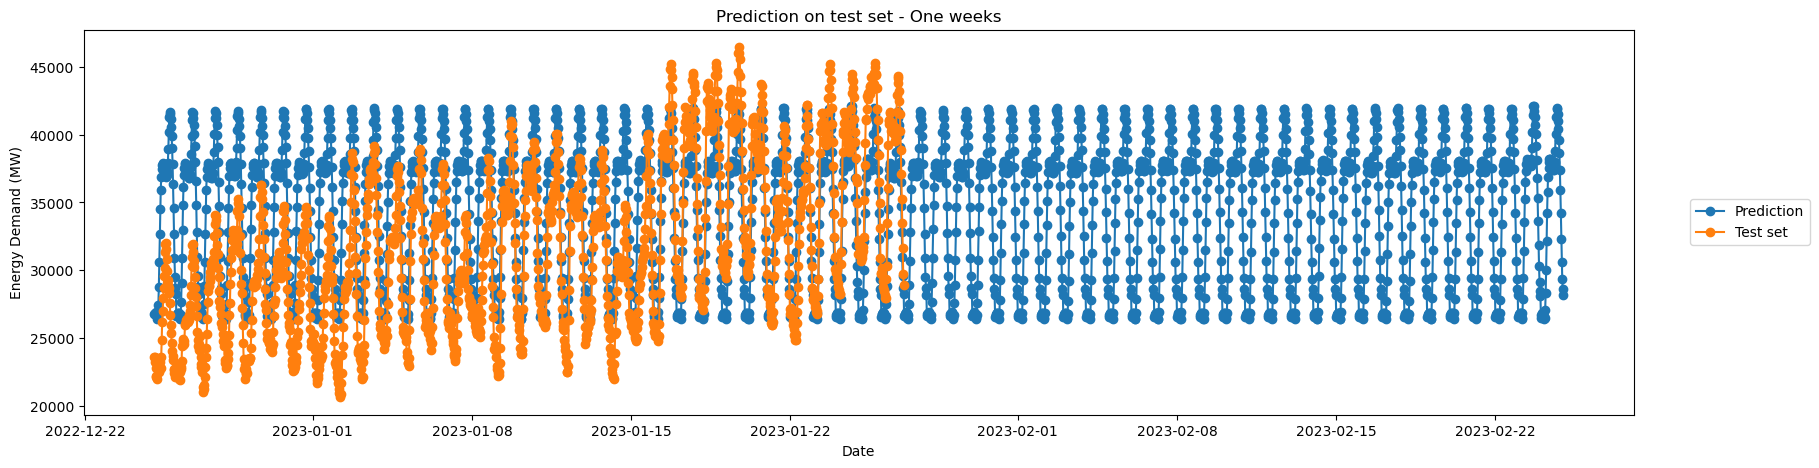

In [215]:
begin = "2022-12-25"
end = "2023-02-25"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    future_df.loc[(future_df.index > begin) & (future_df.index < end)].index,
    future_df.loc[(future_df.index > begin) & (future_df.index < end)]["unscaled"],
    "-o", label="Prediction")

ax.plot(
    df.loc[(df.index > begin) & (df.index < end)].index,
    df.loc[(df.index > begin) & (df.index < end)]["tsd"],
    "-o", label="Test set")




ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - One weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

#### 5.1.2 Weekly Prediction

As can be seen in the plot, the model performs better at predicting the upward and downward trend; nevertheless, there is still a lot of space for improvement in forecasting the peak and the bottom when facing abrupt escalation or steep fall.

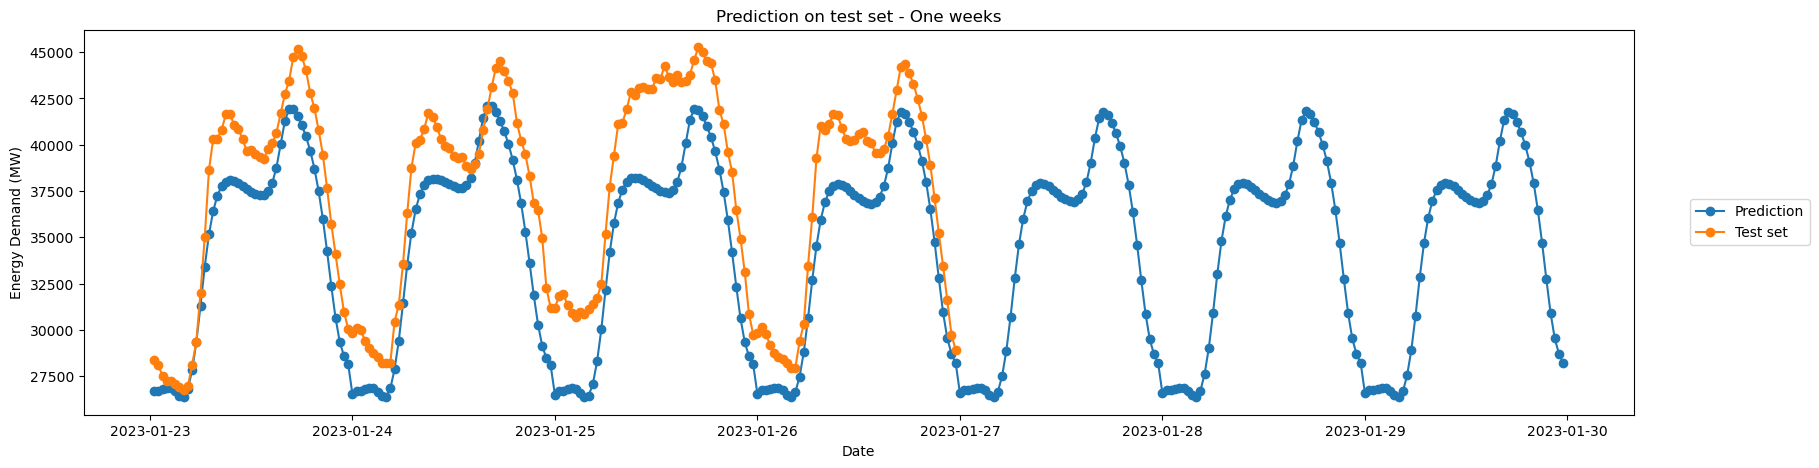

In [218]:
begin = "2023-01-23"
end = "2023-01-30"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    future_df.loc[(future_df.index > begin) & (future_df.index < end)].index,
    future_df.loc[(future_df.index > begin) & (future_df.index < end)]["unscaled"],
    "-o", label="Prediction")

ax.plot(
    df.loc[(df.index > begin) & (df.index < end)].index,
    df.loc[(df.index > begin) & (df.index < end)]["tsd"],
    "-o", label="Test set")




ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - One weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

### 5.2 Model Evaluation 

The following table presented summarizes the performance of the models. It's worth noting that the tuned RandomForest has the highest accuracy of predicting the elctricity demand in the listed models, which demonstrate the fact that it's one of the most effective machine learning algorithm nowadays. However, aside from the result, there are several potentioal reasons that lead to higher rmse for LSTM model. 

First of all, LSTM models are better are handling numerical inputs. If the dataset includes categorical or ordinal features such as "holidays" and time dimension data, the Random Forest model may be better suited to capture this information. Secondly, other potential reason is Random Forest model may have been better tuned leading to better performance since it requires less computational power to test out different combination of hyper-parameters. 

In conclusion, the analysis has shown that both Random Forest and LSTM models have the ability to identify the underlying patterns in data and forecast the next 30 days demand prediction. While Random Forest may perform better in this scenario due to its ability to handle a mix of categorical and ordinal data, LSTM models can be more flexible in handling time series data and capturing long-term dependencies in general.

In [271]:
summary_df = pd.DataFrame(
    {
        "RandomForest - Tuned": [rmse_rf],
        "RNN - Base": [rmse_rnn],
        "LSTM - Base": [rmse_lstm_base],
        "LSTM - Tuned": [rmse_tuned],
        "LSTM - Scheduled": [rmse_scheduled],
        "Metric": ["RMSE"]
    }
)
summary_df = summary_df.set_index("Metric")
display(summary_df)

,RandomForest - Tuned,RNN - Base,LSTM - Base,LSTM - Tuned,LSTM - Scheduled
Metric,,,,,
RMSE,3277.059365,6237.19409,5061.759669,4321.460505,4078.018488


## **6. Limitation**

Firstly, training LSTM models can be computationally expensive, particularly when dealing with large datasets. Secondly, while LSTM models are effective at modeling time series data and capturing long-term dependencies, they may struggle with short-term or rapidly changing trends. For instance, in this case, drop out rate is not apply to the model and that is one potential reason LSTM could mimic the lontrend but not the sudden raise and drop.

Finally, the choice of hyperparameters such as learning rate, batch size can substantially affect the performance of LSTM models, and given the limited resource available, it's not feasible to exhaustively test out a wide range of combination of hyperparameters.

Overall, while LSTM may not perform as well as Random Forest in predict the future eletricity demand in this case, due to it's flexibility and the feature of memory, it is worth using when consider these limitations and adjust the approach as needed to achieve the best possible results.

## 7. Bibliography

National Grid Electricity System Operator. (n.d.). National Grid ESO Open Data Portal. Retrieved Month Day, Year, from https://data.nationalgrideso.com.

## 8. Appendix

### Variables definition

| Variable names | Definition  |
| --- | --- |
| SETTLEMET_DATA | date in format dd/mm/yyyy | 
| SETTLEMENT_PERIOD | half hourly period for the historic outtunr occurred | 
| ND (National Demand) | National Demand is the sum of metered generation, but excludes generation required to meet station load, pump storage pumping and interconnector exports. National Demand is calculated as a sum of generation based on National Grid ESO operational generation metering. Measured in MW. | 
| TSD (Transmission System Demand) | Transmission System Demand is equal to the ND plus the additional generation required to meet station load, pump storage pumping and interconnector exports. Measured in MW. |
|ENGLAND_WALES_DEMAND|England and Wales Demand, as ND above but on an England and Wales basis. Measured in MW.|
|EMBEDDED_WIND_GENERATION|This is an estimate of the GB wind generation from wind farms which do not have Transmission System metering installed. These wind farms are embedded in the distribution network and invisible to National Grid ESO. Their effect is to suppress the electricity demand during periods of high wind. The true output of these generators is not known so an estimate is provided based on National Grid ESO’s best model. Measured in MW.|
|EMBEDDED_WIND_CAPACITY|This is National Grid ESO’s best view of the installed embedded wind capacity in GB. This is based on publicly available information compiled from a variety of sources and is not the definitive view. It is consistent with the generation estimate provided above. Measured in MW|
|EMBEDDED_SOLAR_GENERATION|This is an estimate of the GB solar generation from PV panels. These are embedded in the distribution network and invisible to National Grid ESO. Their effect is to suppress the electricity demand during periods of high radiation. The true output of these generators is not known so an estimate is provided based on National Grid ESO’s best model. Measured in MW.|
|EMBEDDED_SOLAR_CAPACITY|As embedded wind capacity above, but for solar generation. Measured in MW.|